In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

In [8]:
n_samples = 500

[]

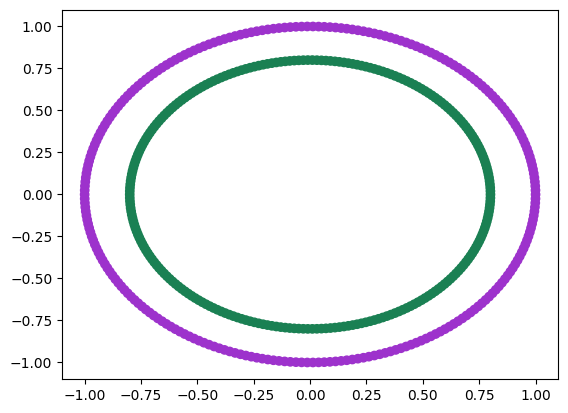

In [9]:
# Se crea el conjunto de datos con la función círculos
X, y = datasets.make_circles(n_samples)
# Se muestran con diferentes colores para cada clase
colors=np.array(['#9D32CC','#1A8053'])
plt.scatter(X[:, 0], X[:,1], c=colors[y])
plt.plot()

Acorde al algoritmo KNN, se tienen que seguir los siguientes pasos:
1. Encontrar las distancias entre el nuevo punto y todos los puntos en el conjunto de datos
2. Encontrar los k más cercanos acorde a la distancia euclidiana
3. Seleccionar la clase mayoritaria para hacer la inferencia

In [10]:
# Nivelación de cargas, donde se distribuyen los datos de la manera más equitativa posible entre los procesadores
# donde se va a procesar el algoritmo KNN

# Se recibe como parámetro el vector a evaluar en los procesadores y el número de procesadores
def nivelacion_cargas(D, n_p):
    # Módulo entre la longitud del vector con datos y el número de procesadores
    # esta parte nos dice cuantos procesadores tendrán más carga que los anteriores
    s=len(D)%n_p
    # La variable t nos dice el tamaño que tendrán las particiones sin tomar
    # en cuenta los que sobran, es decir, la división entera
    t=int((len(D)-s)/n_p)
    # lista de listas, donde se guardan las particiones de cada procesador
    out=[]
    for i in range(n_p):
        if i<s:
            out.append(D[i*t+i:i*t+i+t+1])            
        else:
            out.append(D[i*t+s:i*t+s+t])
    return out

In [11]:
import math
# Paso 1. Encontrar las clases entre cada punto y el cada elemento con el conjunto de datos

# n_p es el número de procesadores donde se hará el procesamiento
n_p=5


cargas=nivelacion_cargas(X, n_p)
k=3


def distancias(D, p, k):
    # Se importan las bibliotecas dentro de las funciones que
    # se van a paralelizar
    import math
    import numpy as np
    dist=[]
    # Se itera sobre todo el conjunto de datos
    for d in D:
        # Se encuentra la distancia con vectorización
        dist.append(math.sqrt(np.sum((d-p)**2)))
    # Se regresan las posiciones de los k más cercanos
    return np.array(dist).argsort()[:k]

# Se imprimen las clases y los puntos 
print(y[distancias(X, X[0], k)])
print(X[distancias(X, X[0], k)])

[1 1 1]
[[ 0.7796215  -0.17941661]
 [ 0.78388404 -0.15976798]
 [ 0.77486653 -0.19895191]]


In [12]:
from multiprocess import Pool
from scipy import stats as st
# Se da un punto arbitrareo
p=X[0]
# Se hace la nivelación de cargas
n_c=nivelacion_cargas(X, n_p)
# Se juntan los parametros para enviarlos a los procesos
parametros=zip(n_c, [p for x in range(n_p)], [k for x in range(n_p)])

# Se hace la nivelación de cargas sobre y
n_cy=nivelacion_cargas(y, n_p)

with Pool(n_p) as pool:
    # Se guardan los resultados en una variable
    resultados = pool.starmap(distancias, parametros)
    # Se crea un nuevo conjunto de datos
    new_x=[]
    new_y=[]
    for i in range(len(resultados)):
        new_x.extend(n_c[i][resultados[i]])
        new_y.extend(n_cy[i][resultados[i]])
    # Se sacan las clases en de acuerdo al nuevo conjunto de datos
    print(np.array(new_y)[distancias(new_x, p, k)])
    # Para sacar la clase mayoritaria se utiliza la moda de las clases que se extrajeron
    print(st.mode(np.array(new_y)[distancias(new_x, p, k)]))
    # En la posición 0 se guarda la moda de los resultados
    print(st.mode(np.array(new_y)[distancias(new_x, p, k)])[0])

[1 1 1]
ModeResult(mode=array([1], dtype=int64), count=array([3]))
[1]


C:\Users\Khoss\AppData\Local\Temp\ipykernel_21308\3324237948.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(st.mode(np.array(new_y)[distancias(new_x, p, k)]))
C:\Users\Khoss\AppData\Local\Temp\ipykernel_21308\3324237948.py:27: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a